# Does model misclassify specific disorder often as PD? Predicted probability for each disorder on test sets 

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import pylab as plt

from scipy import stats
from statannot import add_stat_annotation
from functools import reduce

from importlib import reload
import sys
import os
sys.path.insert(1,'../')
import plots

In [2]:
reload(plots)
image_path = plots.set_dir()
colors = plots.set_colors()
data_path = '/scratch/c.c21013066/data/ukbiobank/analyses/acc_models/noOsteo'

In [3]:
dfs = pd.read_csv('/scratch/c.c21013066/data/ukbiobank/merged_data/populationNoOsteoAllHC.csv',index_col=0)

In [14]:
subplotlabels = [['A','B'],['C','D'],['E','F'],['G','H'],['I','J'],['K','L']]
subplotlabels[0][1]

'B'

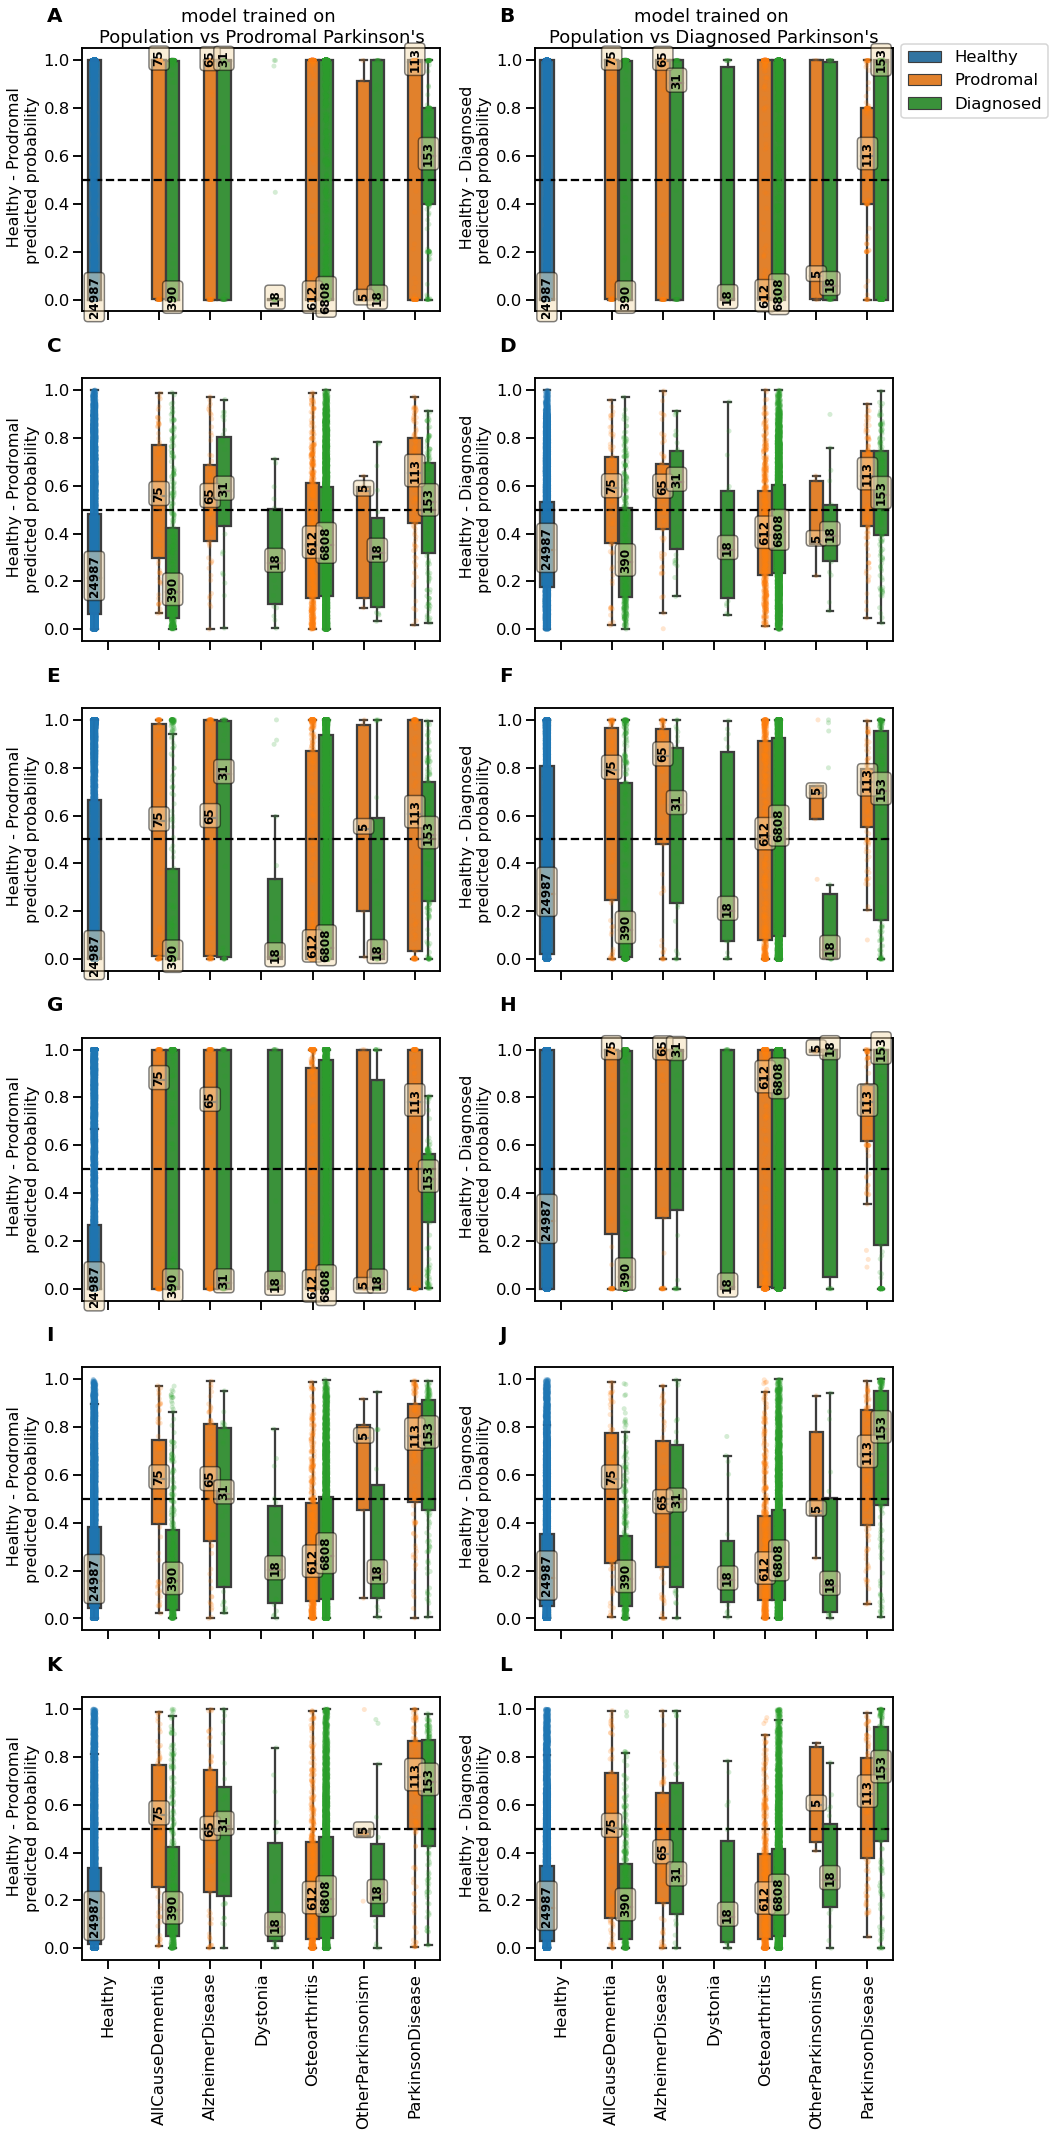

In [17]:
# load predictions
kinds = ['genetics+family','blood','lifestyle_nofam','prodromalsigns_beforePD','all_acc_features',
         'all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD']
diags = ['diag_ProdPopulationNoPD','diag_PDPopulationNoProd']
statuses = [["Prodromal"],['Diseased'],['Prodromal','Diseased']]
status_names = ['Prodromal','Diagnosed','Prodromal &\nDiagnosed']
hue_order=['Healthy','Prodromal','Diagnosed']
order=['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','Osteoarthritis','AllCauseParkinsonism',
                                                                            'ParkinsonDisease']
remove = 20
subplotlabels = [['A','B'],['C','D'],['E','F'],['G','H'],['I','J'],['K','L']]

fig,axes = plt.subplots(ncols=2,nrows=6,figsize=(15,5*6),sharex=True)
plots.plot_context()
    
for j,k in enumerate(kinds):
    for diag,status,status_name,ax,i in zip(diags,statuses,status_names,axes.flatten(),np.arange(len(diags))):
            pred = pd.read_csv(f'{data_path}/{k}/popmodelsNoPD_pred_stacked_allHC.csv',header=[0,1],index_col=[0,1])
            pred = pred.loc[:,(diag,'test')].to_frame().droplevel(level=0,axis=1)
            pred = pred[~pred['test'].isna()]
            #preddf = pd.merge(dfs,pred.loc[:,[(diag,'test')]],right_index=True,left_index=True,how='left')
            # remove PD patients from other diseases
            PDcases = dfs[np.logical_and(dfs['diagnosis']=='ParkinsonDisease',dfs['Status'].isin(statuses[-1]))]
            nonPD = dfs[np.logical_and(dfs['diagnosis']!='ParkinsonDisease',dfs['Status']!='Healthy')]
            nonPD = nonPD.drop(index=np.intersect1d(PDcases.index,nonPD.index))
            # merge HC in one group and drop duplicates
            hc = dfs[dfs['Status']=='Healthy']
            hc = hc[~hc.index.duplicated(keep='first')]
            preddf = pd.concat([PDcases,nonPD,hc])
            preddf['diagnosis'] = [row['diagnosis'] if row['Status']!='Healthy' else 'Healthy' for key,row in preddf.iterrows()]
            preddf = preddf[preddf['diagnosis'].isin(order)]
            preddf = preddf.reset_index().set_index(['eid','diagnosis'])
            merged = pd.merge(preddf,pred,right_index=True,left_index=True,how='right').reset_index().set_index('eid')
            merged['Status'] = merged['Status'].replace(['Diseased'],['Diagnosed'])

            merged_cv = merged.reset_index().groupby(['eid','diagnosis','Status']).first()
            N_diagnosis_group = merged_cv.groupby(['diagnosis','Status']).size()
            N_diagnosis_group = N_diagnosis_group.loc[(order,hue_order)]

            merged_cv = merged.reset_index().groupby(['eid','diagnosis','Status'])['test'].mean().reset_index()
            bp = sns.boxplot(y='test',x='diagnosis',hue='Status',data=merged_cv,showfliers=False,
                             hue_order=['Healthy','Prodromal','Diagnosed'],order=['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','Osteoarthritis','AllCauseParkinsonism',
                                                                                'ParkinsonDisease'],ax=axes[j,i])
            sp = sns.stripplot(y='test',x='diagnosis',hue='Status',data=merged_cv,
                             hue_order=['Healthy','Prodromal','Diagnosed'],dodge=True,alpha=0.2,
                               order=['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','Osteoarthritis','AllCauseParkinsonism',
                                                                                'ParkinsonDisease'],ax=axes[j,i])
            axes[j,i].axhline(0.5,0,1,ls='--',color='k')
            axes[j,i].set_ylabel(f'     Healthy - {status_name}\npredicted probability')
            #axes[j,i].text(-1.3,0.2,f'Healthy - {status_name}',rotation=90)
            if j == (len(kinds) -1):
                axes[j,i].set_xticklabels(['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','Osteoarthritis','OtherParkinsonism',
                                                                                'ParkinsonDisease'],rotation=90);
            else:
                axes[j,i].set_xticklabels([])
            plots.add_median_labels(axes[j,i],N_diagnosis_group,fmt="%d")
            axes[j,i].set_xlabel('')
            #axes[j,i].set_ylim(-0.05,1.05
            if j ==0:
                axes[j,i].set_title(f"model trained on \nPopulation vs {status_name} Parkinson's")
            if i < len(diags) or j > 0:
                axes[j,i].legend([],[], frameon=False)
            axes[j,i].text(-0.1, 1.1, subplotlabels[j][i], transform=axes[j,i].transAxes, 
                size=20, weight='bold')
            if j==0 and i == 1:
                handles, labels = axes[0,1].get_legend_handles_labels()
                axes[0,1].legend(handles=handles[:3],labels=labels[:3],bbox_to_anchor=(1, 1.05))
plt.tight_layout()
plt.savefig(f'{image_path}/barplot_probacombined_populationmodel_allmod_stacked_cv_HCnoOsteo.pdf',dpi=300,bbox_inches='tight')
plt.savefig(f'{image_path}/barplot_probacombined_populationmodel_allmod_stacked_cv_HCnoOsteo.png',dpi=300,bbox_inches='tight')
plt.show()

# Supplemental Figure

In [6]:
# check correlation of predictions
# load predictions
kind = ['intercept','genetics+family','lifestyle_nofam','blood','prodromalsigns_beforePD','all_acc_features',
            'all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD']
diags = ['diag_ProdPopulationNoPD','diag_PDPopulationNoProd']
statuses = [["Prodromal"],['Diseased'],['Prodromal','Diseased']]
status_names = ['Prodromal','Diagnosed','Prodromal & Diagnosed']
hue_order=['Healthy','Prodromal','Diagnosed']
order=['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','Osteoarthritis','AllCauseParkinsonism',
                                                                            'ParkinsonDisease']

mergeds = []
for diag,status,status_name,i in zip(diags,statuses,status_names,np.arange(len(diags))):
    merged_cvs = []
    for k in kind:
        pred = pd.read_csv(f'{data_path}/{k}/popmodelsNoPD_pred_stacked_allHC.csv',header=[0,1],index_col=[0,1])
        pred = pred.loc[:,(diag,'test')].to_frame().droplevel(level=0,axis=1)
        pred = pred[~pred['test'].isna()]
        #preddf = pd.merge(dfs,pred.loc[:,[(diag,'test')]],right_index=True,left_index=True,how='left')
        # remove PD patients from other diseases
        PDcases = dfs[np.logical_and(dfs['diagnosis']=='ParkinsonDisease',dfs['Status'].isin(status))]
        nonPD = dfs[np.logical_and(dfs['diagnosis']!='ParkinsonDisease',dfs['Status']!='Healthy')]
        nonPD = nonPD.drop(index=np.intersect1d(PDcases.index,nonPD.index))
        # merge HC in one group and drop duplicates
        hc = dfs[dfs['Status']=='Healthy']
        hc = hc[~hc.index.duplicated(keep='first')]
        preddf = pd.concat([PDcases,nonPD,hc])
        preddf['diagnosis'] = [row['diagnosis'] if row['Status']!='Healthy' else 'Healthy' for key,row in preddf.iterrows()]
        preddf = preddf[preddf['diagnosis'].isin(order)]
        preddf = preddf.reset_index().set_index(['eid','diagnosis'])
        merged = pd.merge(preddf,pred,right_index=True,left_index=True,how='right').reset_index().set_index('eid')
        merged['Status'] = merged['Status'].replace(['Diseased'],['Diagnosed'])
        
        merged_cv = merged.reset_index().groupby(['eid','diagnosis','Status']).first()
        N_diagnosis_group = merged_cv.groupby(['diagnosis','Status']).size()
        N_diagnosis_group = N_diagnosis_group.loc[(order,hue_order)]

        merged_cv = merged.reset_index().groupby(['eid','diagnosis','Status'])['test'].mean().reset_index()
        merged_cv = merged_cv.rename(columns={'test':k})
        merged_cvs.append(merged_cv)
    merged = reduce(lambda  left,right: pd.merge(left,right,on=['eid','diagnosis','Status'],
                                            how='outer'), merged_cvs)
    mergeds.append(merged)

In [8]:
mergeds[1].describe()

,eid,intercept,genetics+family,lifestyle_nofam,blood,prodromalsigns_beforePD,all_acc_features,all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD
count,3.316200e+04,33162.000000,3.316200e+04,3.316200e+04,3.316200e+04,3.316200e+04,33162.000000,33162.000000
mean,3.514170e+06,0.733984,3.698775e-01,3.518546e-01,4.036192e-01,5.757799e-01,0.251534,0.234327
std,1.445628e+06,0.219546,4.682119e-01,3.638415e-01,2.111302e-01,4.009401e-01,0.233396,0.226574
min,1.000057e+06,0.498689,3.693422e-67,2.648916e-09,5.193522e-07,3.143114e-80,0.000000,0.000000
25%,2.257065e+06,0.580884,6.114294e-13,1.855008e-02,2.315739e-01,1.722489e-01,0.057813,0.035573
50%,3.526068e+06,0.590265,1.163434e-04,1.889089e-01,3.901802e-01,6.193898e-01,0.185009,0.178753
75%,4.763930e+06,1.000000,9.999344e-01,6.954833e-01,5.614592e-01,9.999993e-01,0.383179,0.363949
max,6.024521e+06,1.000000,1.000000e+00,1.000000e+00,9.990971e-01,1.000000e+00,0.999952,1.000000


In [7]:
corr = pd.DataFrame(index = pd.MultiIndex.from_product([kind,kind],names=['modality 1','modality 2']),columns=['pearsonr','p-value'])
for i,k in enumerate(kind):
    for j,k2 in enumerate(kind):
        #if j>i:
            r,p = stats.pearsonr(mergeds[0][k],mergeds[0][k2])
            corr.loc[(k,k2),'pearsonr'] = r
            corr.loc[(k,k2),'p-value'] = p
#corr = corr.dropna(axis='rows',how='all')

In [8]:
corr['pearsonr'].unstack().astype(float).loc[kind,kind]

modality 2,intercept,genetics+family,lifestyle_nofam,blood,prodromalsigns_beforePD,all_acc_features,all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD
modality 1,,,,,,,
intercept,1.000000,0.005171,0.110761,0.007814,0.009087,0.005468,0.012605
genetics+family,0.005171,1.000000,0.002117,0.386459,0.329500,0.304804,-0.002600
lifestyle_nofam,0.110761,0.002117,1.000000,0.001543,0.000499,0.000082,0.390127
blood,0.007814,0.386459,0.001543,1.000000,0.510010,0.528397,-0.006554
prodromalsigns_beforePD,0.009087,0.329500,0.000499,0.510010,1.000000,0.398277,-0.003012
all_acc_features,0.005468,0.304804,0.000082,0.528397,0.398277,1.000000,-0.011527
all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD,0.012605,-0.002600,0.390127,-0.006554,-0.003012,-0.011527,1.000000


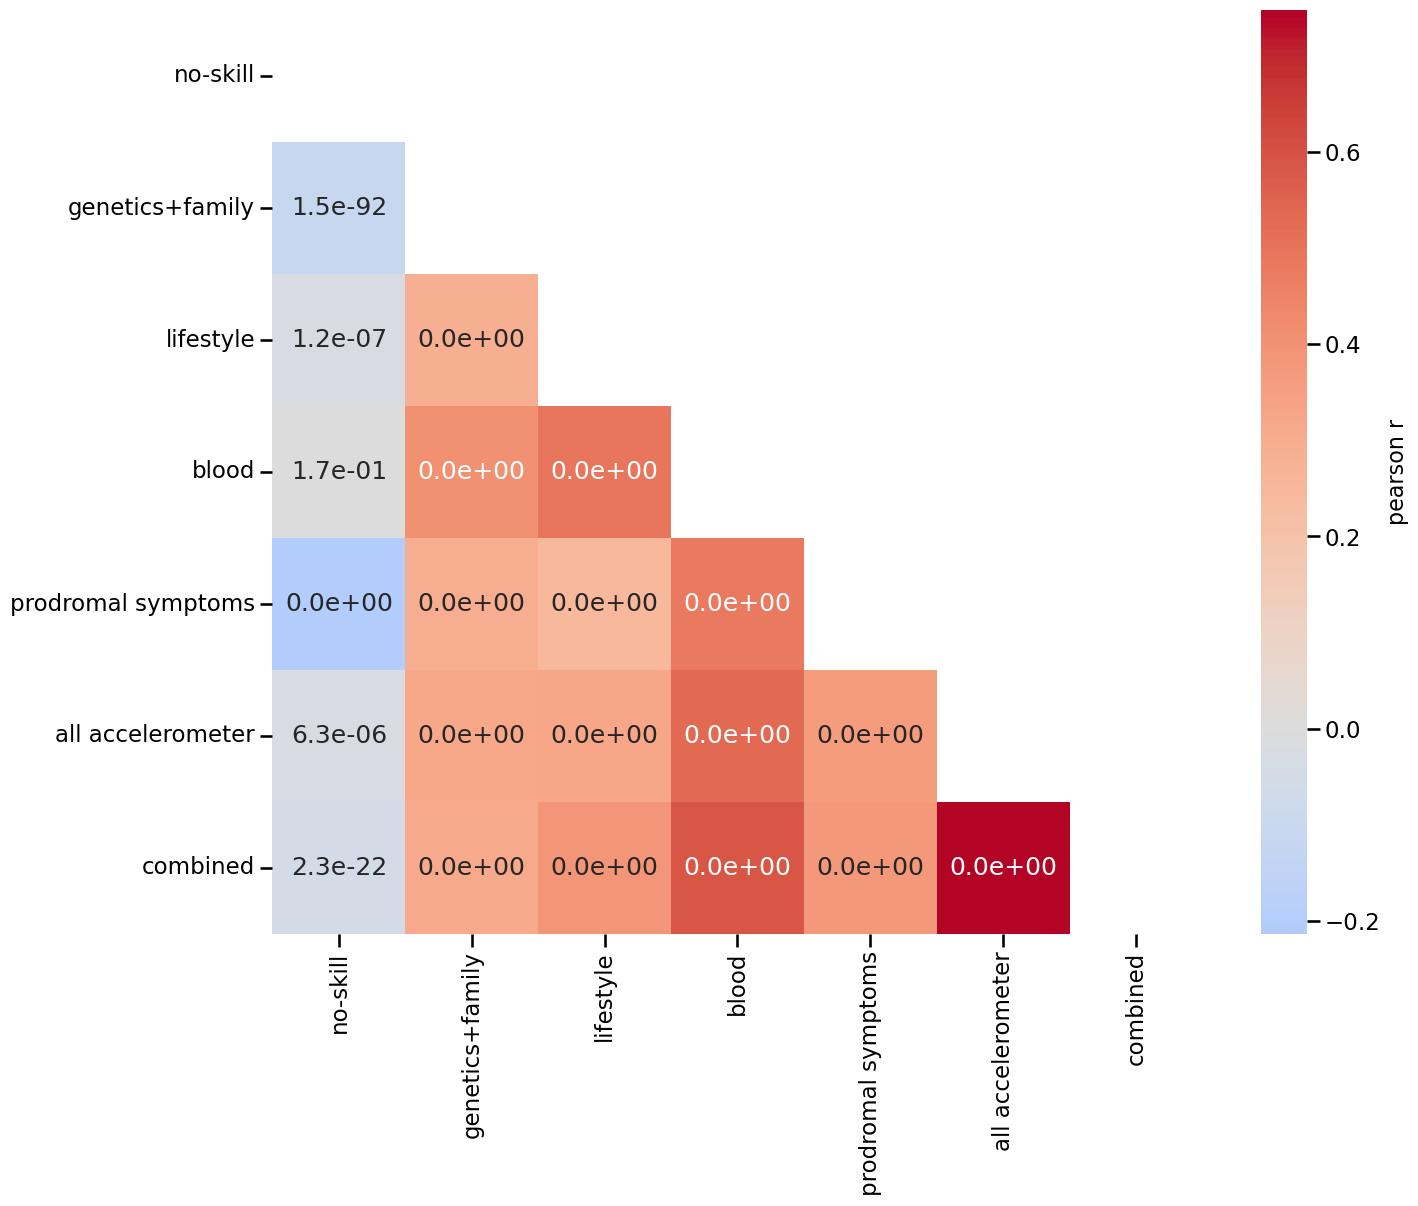

In [8]:
order=['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','Osteoarthritis','AllCauseParkinsonism',
                                                                            'ParkinsonDisease']
fig = plt.figure(figsize=(15,12))
plots.plot_context()
ax = sns.heatmap(corr['pearsonr'].unstack().astype(float).loc[kind,kind],cmap='coolwarm',center=0,
                 annot=corr['p-value'].unstack().astype(float).loc[kind,kind],fmt='.1e',xticklabels=['no-skill','genetics+family','lifestyle','blood','prodromal symptoms',
                                                'all accelerometer','combined'], yticklabels=['no-skill','genetics+family','lifestyle','blood','prodromal symptoms',
                                                'all accelerometer','combined'],cbar_kws={'label': 'pearson r'},mask=np.triu(corr['pearsonr'].unstack().astype(float).loc[kind,kind]))
ax.set_xlabel('')
ax.set_ylabel('');
plt.savefig(f'{image_path}/testpredcorr.png',dpi=300,bbox_inches='tight')
plt.savefig(f'{image_path}/testpredcorr.pdf',dpi=300,bbox_inches='tight')